In [7]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier

In [8]:
star_data = pd.read_csv('/Users/katyaluchette/Downloads/star_data.csv')

In [9]:
star_data.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M


In [10]:
star_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
 6   Spectral Class          240 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 13.2+ KB


In [11]:
star_data.describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


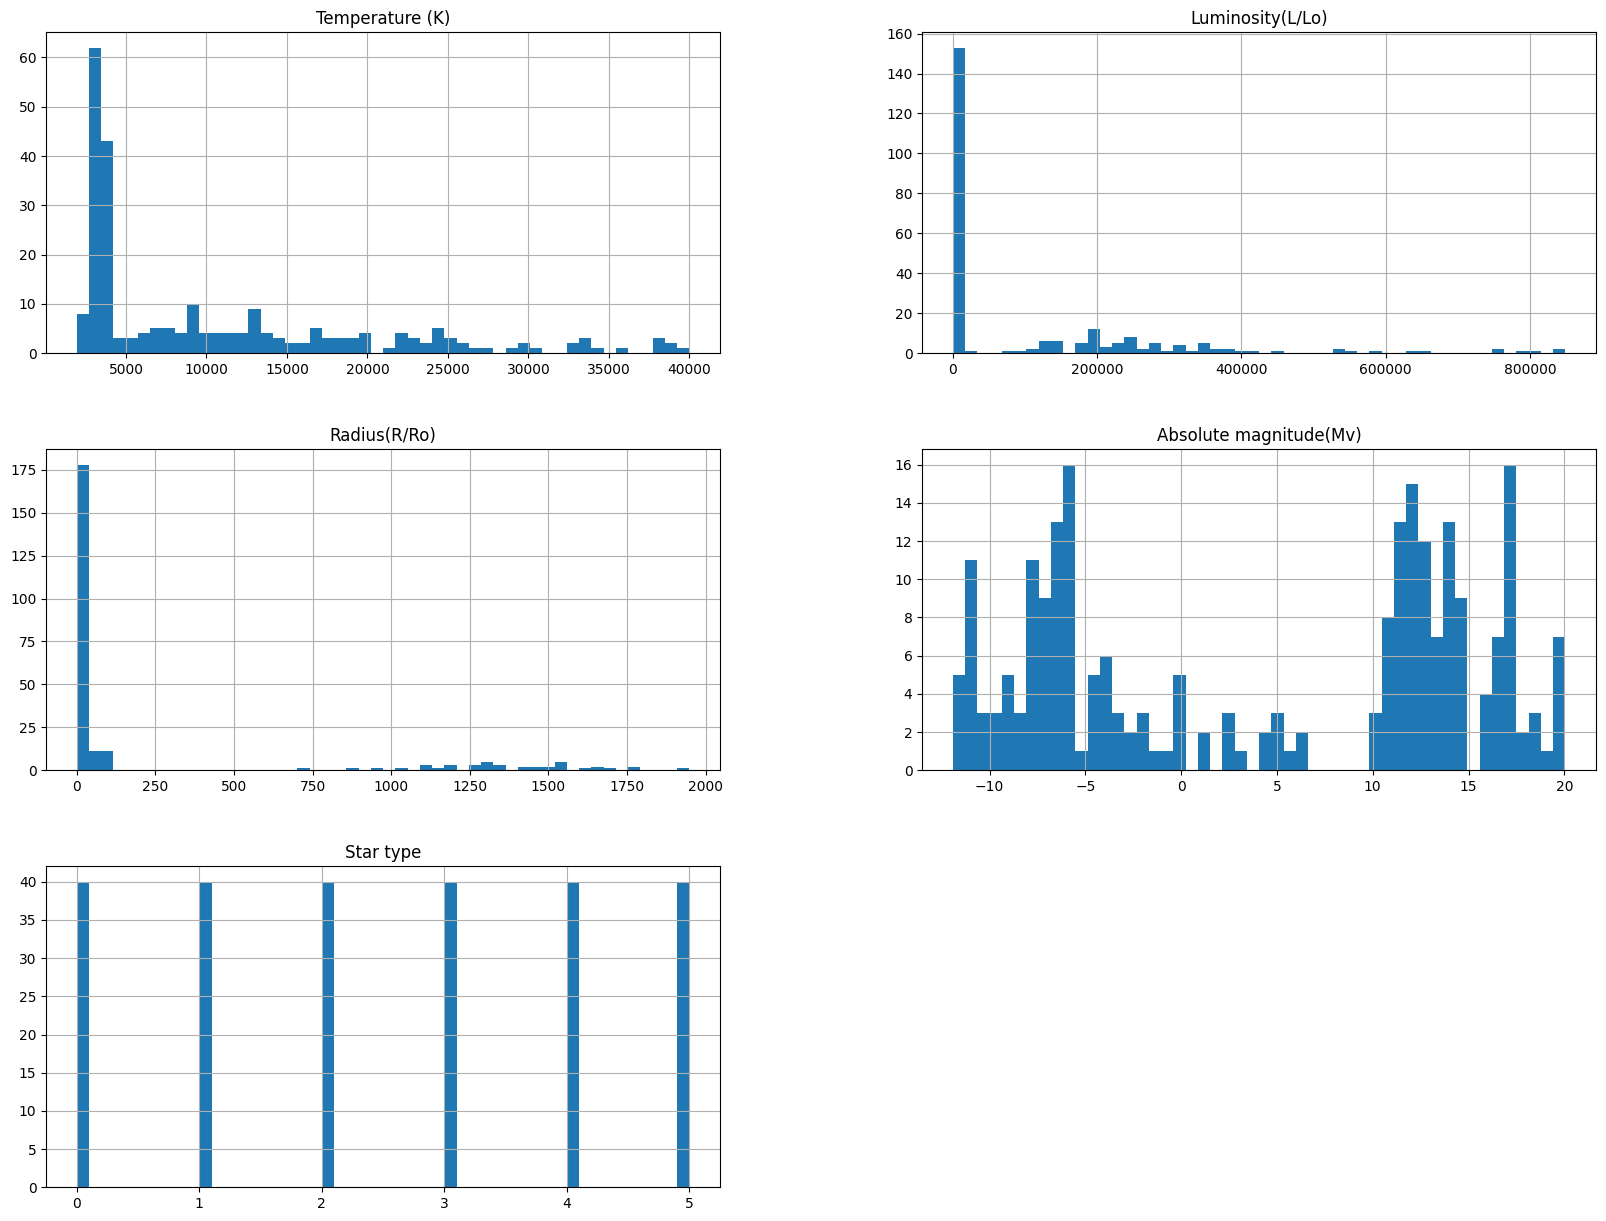

In [12]:
import matplotlib.pyplot as plt
star_data.hist(bins=50, figsize=(20,15))
plt.show()

In [13]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(star_data, test_size=0.2, random_state=42)

In [14]:
stars = train_set.copy()

<function matplotlib.pyplot.show(close=None, block=None)>

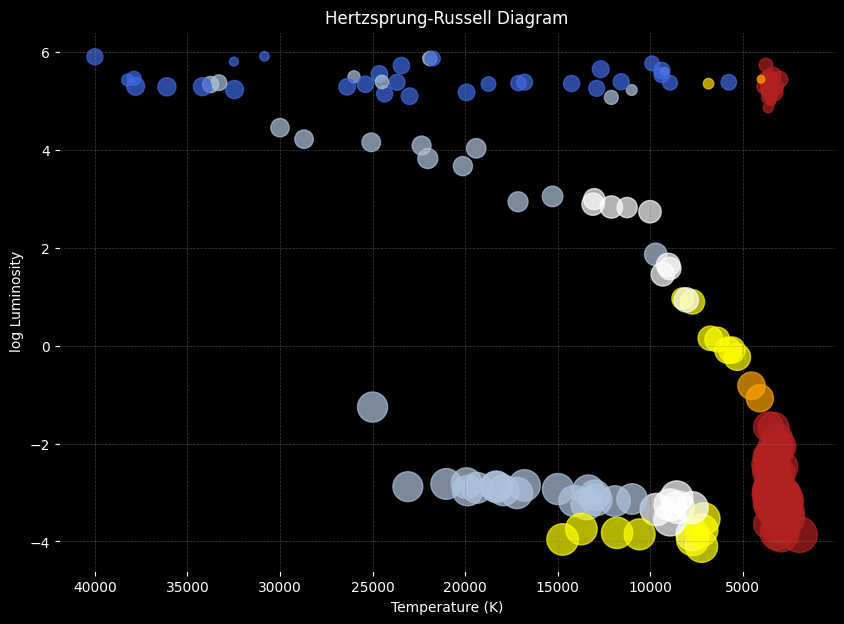

In [15]:
def spectral_class_to_color(spectral_class):
    if spectral_class == "M":
        return "firebrick"
    if spectral_class == "O":
        return "royalblue"
    if spectral_class == "B":
        return "lightsteelblue"
    if spectral_class == "F":
        return "yellow"
    if spectral_class == "A":
        return "white"
    if spectral_class == "G":
        return "gold"
    if spectral_class == "K":
        return "orange"


stars["log_Luminosity"] = np.log10(stars["Luminosity(L/Lo)"])
stars["color"] = stars["Spectral Class"].apply(spectral_class_to_color)

fig, ax = plt.subplots(figsize = (10,7))

scatter = ax.scatter(
    stars["Temperature (K)"],
    stars["log_Luminosity"],
    c = stars["color"],
    s = (stars["Absolute magnitude(Mv)"] - stars["Absolute magnitude(Mv)"].min() + 1) * 20,
    alpha = 0.7
)

ax.invert_xaxis()

ax.set_title("Hertzsprung-Russell Diagram", color="white")
ax.set_xlabel("Temperature (K)", color="white")
ax.set_ylabel("log Luminosity", color="white")

ax.set_facecolor("black")
fig.patch.set_facecolor("black")

ax.grid(color = "gray", linestyle = "--", linewidth = 0.5, alpha = 0.5)
ax.tick_params(colors="white")

plt.show


In [16]:
stars_for_corr = train_set.copy()

In [17]:
corr_matrix = stars_for_corr.corr(numeric_only = True)

In [18]:
corr_matrix["Star type"].sort_values(ascending=False)

Star type                 1.000000
Luminosity(L/Lo)          0.677385
Radius(R/Ro)              0.645644
Temperature (K)           0.414871
Absolute magnitude(Mv)   -0.952069
Name: Star type, dtype: float64

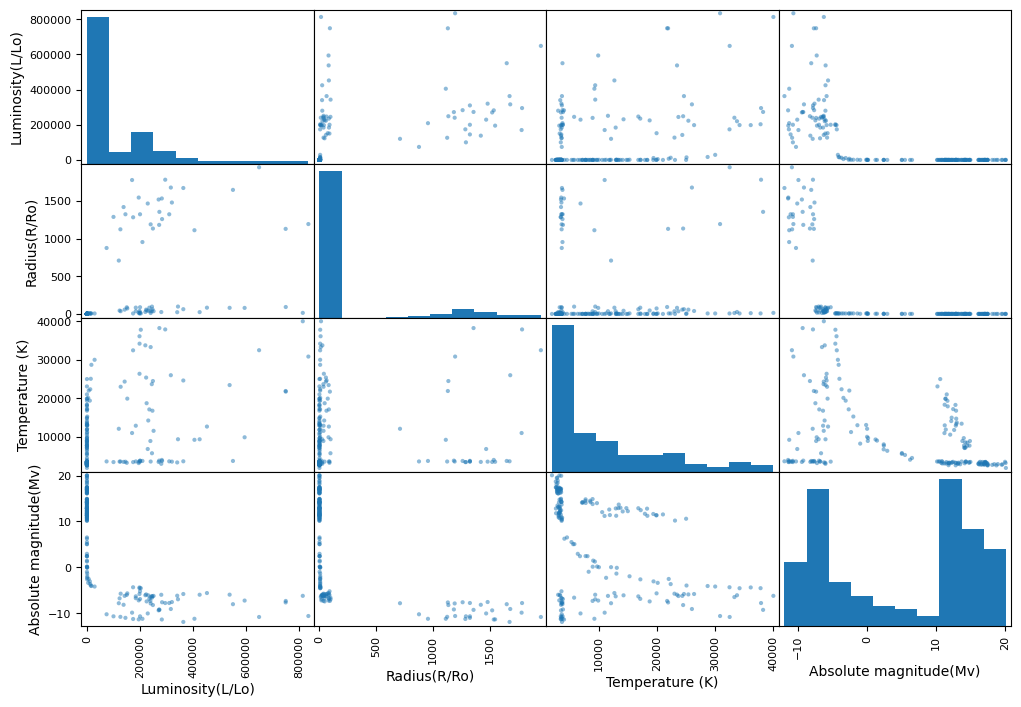

In [19]:
from pandas.plotting import scatter_matrix

attributes = ["Luminosity(L/Lo)", "Radius(R/Ro)", "Temperature (K)", "Absolute magnitude(Mv)"]
scatter_matrix(stars_for_corr[attributes], figsize=(12,8))
plt.show()

In [20]:
stars_for_corr["log Luminosity"] = np.log10(stars["Luminosity(L/Lo)"])

In [21]:
corr_matrix = stars_for_corr.corr(numeric_only=True)
corr_matrix["Star type"].sort_values(ascending=False)

Star type                 1.000000
log Luminosity            0.898097
Luminosity(L/Lo)          0.677385
Radius(R/Ro)              0.645644
Temperature (K)           0.414871
Absolute magnitude(Mv)   -0.952069
Name: Star type, dtype: float64

In [22]:
stars = train_set.drop("Star type", axis=1)
stars_labels = train_set["Star type"].copy()

In [23]:
stars_labels.value_counts()

Star type
2    34
1    33
0    32
4    32
3    32
5    29
Name: count, dtype: int64

In [24]:
stars["Spectral Class"].value_counts()

Spectral Class
M    90
B    36
O    30
A    17
F    15
K     3
G     1
Name: count, dtype: int64

In [25]:
stars["Star color"].value_counts()

Star color
Red                   91
Blue                  43
Blue-white            20
yellow-white           7
Blue White             7
White                  6
white                  3
Blue white             3
yellowish              2
Yellowish White        2
Whitish                2
Blue white             1
Orange                 1
White-Yellow           1
Pale yellow orange     1
Blue                   1
Blue-White             1
Name: count, dtype: int64

In [26]:
## idea from https://www.kaggle.com/code/eynardm/startypeprediction-100-star-data#Preprocessing
def fix_spelling_star_color(color):
    color = color.lower()
    if "yellow" in color and "white" in color:
        return "white yellow"
    else: 
        color = color.strip()
        color = color.replace("-", " ")
        return color

In [27]:
stars["Star color"] = stars["Star color"].apply(fix_spelling_star_color)

In [28]:
stars["Star color"].value_counts()

Star color
red                   91
blue                  44
blue white            32
white yellow          10
white                  9
whitish                2
yellowish              2
pale yellow orange     1
orange                 1
Name: count, dtype: int64

In [29]:
stars_cat = stars[["Star color", "Spectral Class"]]
encoder = OneHotEncoder(sparse_output=False)
encoded_data = encoder.fit_transform(stars_cat)
encoded_stars = pd.DataFrame(encoded_data, columns = encoder.get_feature_names_out(["Star color", "Spectral Class"]))
encoded_stars.index = stars.drop(["Star color", "Spectral Class"], axis=1).index
stars_encoded = pd.concat([stars.drop(["Star color", "Spectral Class"], axis=1), encoded_stars], axis=1)


In [30]:
stars_encoded["log Luminosity"] = np.log10(stars["Luminosity(L/Lo)"])

In [31]:
stars_encoded.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star color_blue,Star color_blue white,Star color_orange,Star color_pale yellow orange,Star color_red,Star color_white,...,Star color_whitish,Star color_yellowish,Spectral Class_A,Spectral Class_B,Spectral Class_F,Spectral Class_G,Spectral Class_K,Spectral Class_M,Spectral Class_O,log Luminosity
139,3541,0.001300,0.2560,14.33,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-2.886057
60,3341,0.005600,0.0570,16.23,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-2.251812
204,18340,0.001340,0.0124,11.22,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-2.872895
186,2968,0.000461,0.1190,17.45,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-3.336299
207,23092,0.001320,0.0104,10.18,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-2.879426


In [32]:
scaler = RobustScaler(quantile_range = (25.0, 75.0))
scaled_data = scaler.fit_transform(stars_encoded)
stars_scaled = pd.DataFrame(scaled_data, columns=stars_encoded.columns)


In [33]:
stars_scaled.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star color_blue,Star color_blue white,Star color_orange,Star color_pale yellow orange,Star color_red,Star color_white,...,Star color_whitish,Star color_yellowish,Spectral Class_A,Spectral Class_B,Spectral Class_F,Spectral Class_G,Spectral Class_K,Spectral Class_M,Spectral Class_O,log Luminosity
0,-0.202767,-7.846154e-08,-0.010613,0.194734,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.130327
1,-0.220912,-5.641026e-08,-0.016043,0.289121,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.054517
2,1.139850,-7.825641e-08,-0.017260,0.040238,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.128754
3,-0.254752,-8.276410e-08,-0.014351,0.349727,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.184144
4,1.570968,-7.835897e-08,-0.017314,-0.011426,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.129534


In [39]:
tree_classifier = DecisionTreeClassifier(max_depth=7, random_state=42)
tree_classifier.fit(stars_scaled, stars_labels)

DecisionTreeClassifier(max_depth=7, random_state=42)

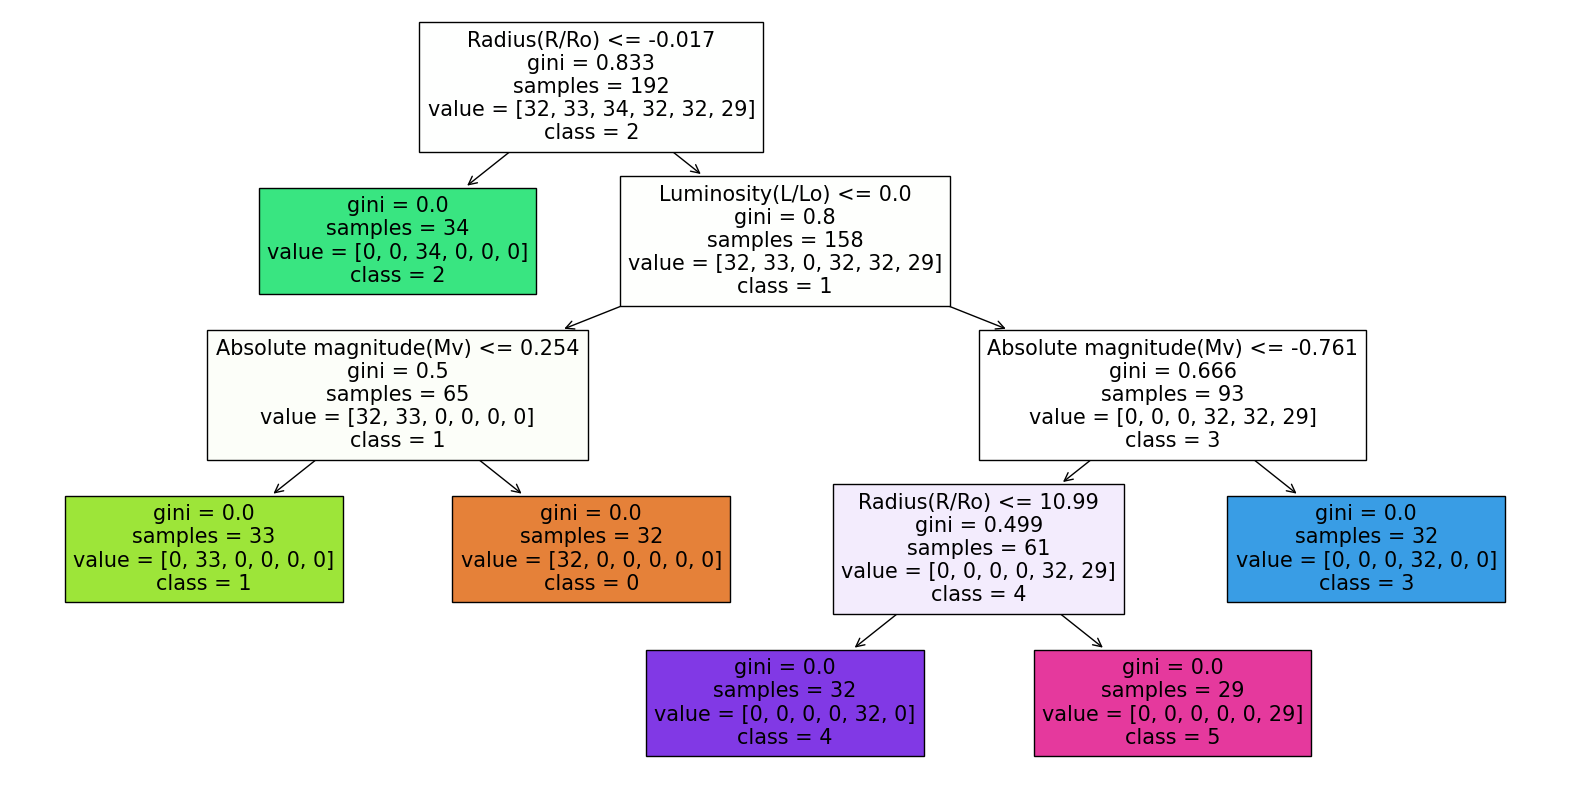

In [41]:
from sklearn.tree import plot_tree

class_names = tree_classifier.classes_

plt.figure(figsize=(20, 10))  # Adjust size as needed
plot_tree(tree_classifier,
          feature_names=["Temperature (K)", 
                         "Luminosity(L/Lo)", 
                         "Radius(R/Ro)", 
                         "Absolute magnitude(Mv)",
                         "Star color_blue",
                         "Star color_blue white",
                         "Star color_orange",
                         "Star color_pale yellow orange",
                         "Star color_red",
                         "Star color_white",
                         "Star color_white yellow",
                         "Star color_whitish",
                         "Star color_yellowish",
                         "Spectral Class_A",
                         "Spectral Class_B",
                         "Spectral Class_F",
                         "Spectral Class_G",
                         "Spectral Class_K",
                         "Spectral Class_M",
                         "Spectral Class_O",
                         "log Luminosity"],
          class_names=class_names.astype(str).tolist(),
          filled=True)
plt.show()